In [1]:
import matplotlib.pyplot as plt
import networkx as nx


Durée totale du projet : 14 jours
Chemin critique :
alpha (0 jours)
Définition des besoins (7 jours)
Choix techno Équipe 2 (7 jours)
Dév pipeline Équipe 2 (21 jours)
Dév modèle (14 jours)
Intégration (14 jours)
Tests (7 jours)
Documentation (7 jours)
Présentation finale (7 jours)
omega (0 jours)


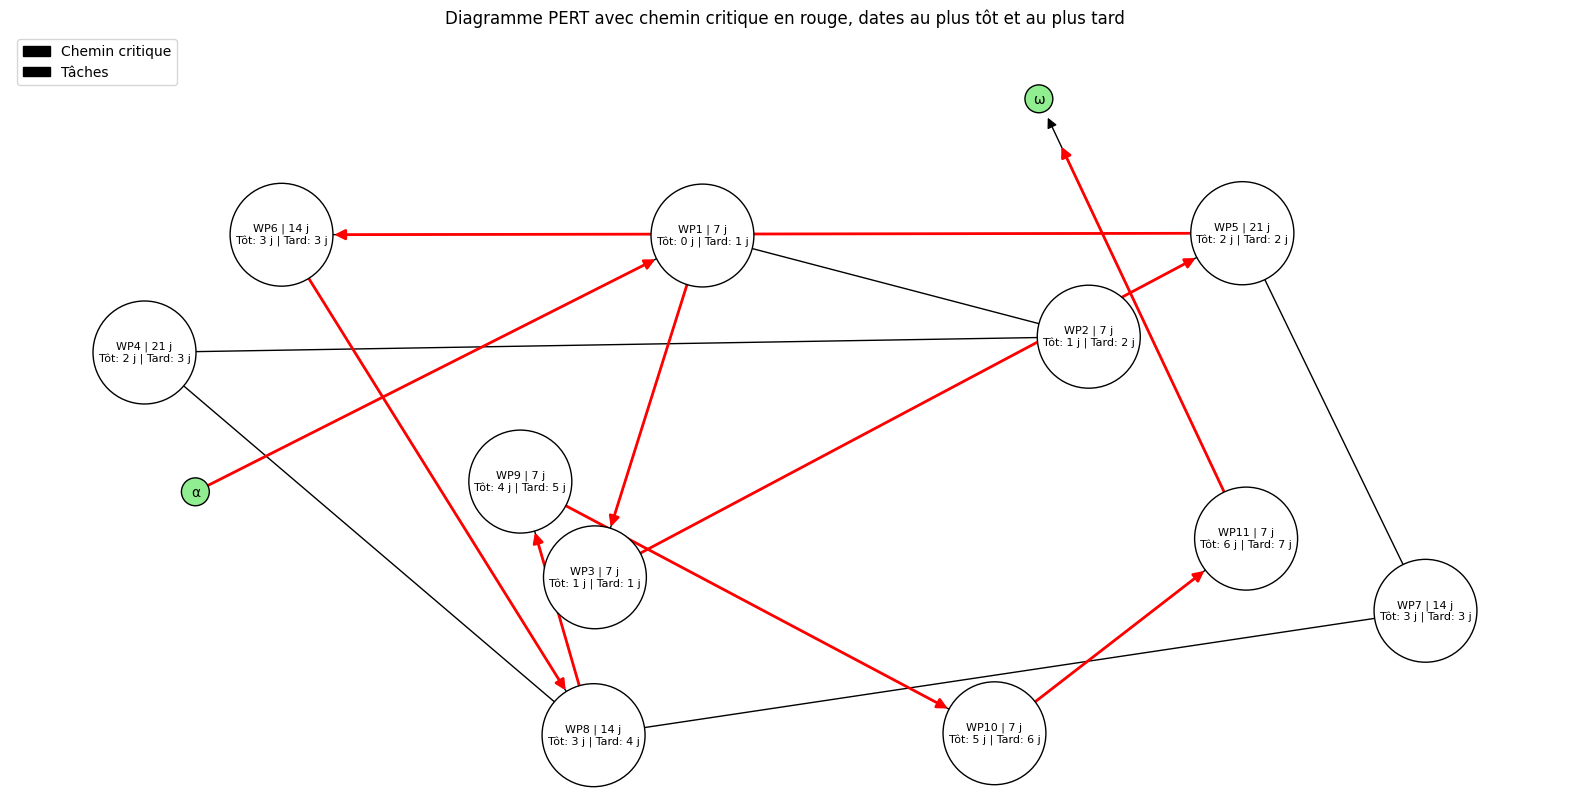

In [22]:
from dataclasses import dataclass
import networkx as nx
import matplotlib.pyplot as plt

@dataclass
class Task:
    name: str
    wp_name: str
    duration: int

def compute_total_duration(G):
    try:
        total_duration = nx.dag_longest_path_length(G, weight='duration')
        return total_duration
    except nx.NetworkXUnfeasible:
        print("Le graphe contient un cycle. Veuillez corriger les dépendances.")
        return None

def find_critical_path(G):
    try:
        critical_path = nx.dag_longest_path(G, weight='duration')
        return critical_path
    except nx.NetworkXUnfeasible:
        print("Le graphe contient un cycle. Impossible de trouver le chemin critique.")
        return None

def create_pert_graph(tasks, dependencies):
    G = nx.DiGraph()
    
    # Ajouter les nœuds avec les attributs
    for task_id, task in tasks.items():
        G.add_node(task_id, name=task.name, duration=task.duration)

    # Ajouter les arcs (dépendances)
    for dep in dependencies:
        G.add_edge(dep[0], dep[1])

    # Ajouter les sommets fictifs α et ω
    G.add_node('alpha', name='α', duration=0)
    G.add_node('omega', name='ω', duration=0)

    # Relier α aux sommets sans prédécesseurs
    for node in G.nodes:
        if G.in_degree(node) == 0 and node != 'alpha' and node != 'omega':
            G.add_edge('alpha', node, duration=0)

    # Relier les sommets sans successeurs à ω
    for node in G.nodes:
        if G.out_degree(node) == 0 and node != 'alpha' and node != 'omega':
            G.add_edge(node, 'omega', duration=tasks[node].duration if node in tasks else 0)

    return G

# Définition des tâches avec leurs durées
tasks = {
    'WP1': Task('Définition des besoins', 'WP1', 7),
    'WP2': Task('Choix techno Équipe 1', 'WP2', 7),
    'WP3': Task('Choix techno Équipe 2', 'WP3', 7),
    'WP4': Task('Dév pipeline Équipe 1', 'WP4', 21),
    'WP5': Task('Dév pipeline Équipe 2', 'WP5', 21),
    'WP6': Task('Dév modèle', 'WP6', 14),
    'WP7': Task('Dév application', 'WP7', 14),
    'WP8': Task('Intégration', 'WP8', 14),
    'WP9': Task('Tests', 'WP9', 7),
    'WP10': Task('Documentation', 'WP10', 7),
    'WP11': Task('Présentation finale', 'WP11', 7),
}

# Définition des dépendances
dependencies = [
    ('WP1', 'WP2'),
    ('WP1', 'WP3'),
    ('WP2', 'WP4'),
    ('WP3', 'WP5'),
    ('WP4', 'WP8'),
    ('WP5', 'WP6'),
    ('WP5', 'WP7'),
    ('WP6', 'WP8'),
    ('WP7', 'WP8'),
    ('WP8', 'WP9'),
    ('WP9', 'WP10'),
    ('WP10', 'WP11')
]

# Création du graphe PERT
G = create_pert_graph(tasks, dependencies)

# Calcul de la durée totale du projet
total_duration = compute_total_duration(G)
print(f"Durée totale du projet : {total_duration} jours")

# Trouver le chemin critique
critical_path = find_critical_path(G)
print("Chemin critique :")
for task_id in critical_path:
    task = tasks.get(task_id, Task(task_id, task_id, 0))
    print(f"{task.name} ({task.duration} jours)")

# Calcul des dates au plus tôt et au plus tard
early_start = nx.single_source_dijkstra_path_length(G, 'alpha', weight='duration')
late_start = nx.single_source_dijkstra_path_length(nx.reverse_view(G), 'omega', weight='duration')
latest_time = total_duration if total_duration else 0

# Génération du graphe PERT avec des cercles en tant que nœuds
pos = nx.spring_layout(G, k=1.5, seed=42)  # Utiliser une disposition en ressort pour espacer les nœuds et les lire de gauche à droite
plt.figure(figsize=(20, 10))

# Dessiner les nœuds avec des cercles et une matrice 2x2 à l'intérieur
for node in G.nodes:
    if node in ['alpha', 'omega']:
        label = G.nodes[node]['name']
        plt.text(pos[node][0], pos[node][1], label, fontsize=10, ha='center', va='center', bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='circle,pad=0.5'))
    else:
        task = tasks[node]
        early = early_start.get(node, 0)
        late = latest_time - late_start.get(node, 0)
        matrix_text = f"{task.wp_name} | {task.duration} j\nTôt: {early} j | Tard: {late} j"
        plt.text(pos[node][0], pos[node][1], matrix_text, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle,pad=0.5'))

# Dessiner les arêtes
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowstyle='-|>', arrowsize=15, min_target_margin=15)

# Mettre en évidence le chemin critique
critical_edges = list(zip(critical_path, critical_path[1:]))
nx.draw_networkx_edges(
    G, pos,
    edgelist=critical_edges,
    edge_color='r',
    width=2,
    arrowstyle='-|>',
    arrowsize=15,
    min_target_margin=37
)

# Ajouter la légende
plt.legend(['Chemin critique', 'Tâches'], loc='upper left')

plt.title("Diagramme PERT avec chemin critique en rouge, dates au plus tôt et au plus tard")
plt.axis('off')
plt.show()